In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tqdm.autonotebook import tqdm
import numpy as np 
import pandas as pd 
import matplotlib.image as mpimg
from keras import Sequential
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Flatten,Dense,BatchNormalization,Activation,Dropout
from keras.layers import Lambda, Input, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from keras.preprocessing.image import load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.applications.xception import Xception, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.nasnet import NASNetLarge, preprocess_input
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
import time 
print('yee')

yee


C:\Users\Brion\AppData\Local\Temp/ipykernel_20036/3021708480.py:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
labels = pd.read_csv('Database1/labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
breed = sorted(list(set(labels['breed'])))
n_breed = len(breed)
print('Total unique breed {}'.format(n_breed))
breed_to_num = dict(zip(breed, range(n_breed)))
breed_to_num

Total unique breed 120


{'affenpinscher': 0,
 'afghan_hound': 1,
 'african_hunting_dog': 2,
 'airedale': 3,
 'american_staffordshire_terrier': 4,
 'appenzeller': 5,
 'australian_terrier': 6,
 'basenji': 7,
 'basset': 8,
 'beagle': 9,
 'bedlington_terrier': 10,
 'bernese_mountain_dog': 11,
 'black-and-tan_coonhound': 12,
 'blenheim_spaniel': 13,
 'bloodhound': 14,
 'bluetick': 15,
 'border_collie': 16,
 'border_terrier': 17,
 'borzoi': 18,
 'boston_bull': 19,
 'bouvier_des_flandres': 20,
 'boxer': 21,
 'brabancon_griffon': 22,
 'briard': 23,
 'brittany_spaniel': 24,
 'bull_mastiff': 25,
 'cairn': 26,
 'cardigan': 27,
 'chesapeake_bay_retriever': 28,
 'chihuahua': 29,
 'chow': 30,
 'clumber': 31,
 'cocker_spaniel': 32,
 'collie': 33,
 'curly-coated_retriever': 34,
 'dandie_dinmont': 35,
 'dhole': 36,
 'dingo': 37,
 'doberman': 38,
 'english_foxhound': 39,
 'english_setter': 40,
 'english_springer': 41,
 'entlebucher': 42,
 'eskimo_dog': 43,
 'flat-coated_retriever': 44,
 'french_bulldog': 45,
 'german_shepherd'

In [4]:
input_shape = (331,331,3)
def imagesarray(directory, label_dataframe, target_size = input_shape):
    image_labels = label_dataframe['breed']
    images = np.zeros([len(label_dataframe), target_size[0], target_size[1], target_size[2]],dtype=np.uint8)
    y = np.zeros([len(label_dataframe),1],dtype = np.uint8)
    for ix, image_name in enumerate(tqdm(label_dataframe['id'].values)):
        img_dir = os.path.join(directory, image_name + '.jpg')
        img = load_img(img_dir, target_size = target_size)
        images[ix]=img
        del img  
        dog_breed = image_labels[ix]
        y[ix] = breed_to_num[dog_breed]
    y = to_categorical(y)
    return images,y
print('yee')

yee


In [5]:
t = time.time()
X,y = imagesarray('Database1/train', labels[:])
print('runtime in seconds: {}'.format(time.time() - t))

  0%|          | 0/10222 [00:00<?, ?it/s]

runtime in seconds: 24.978551626205444


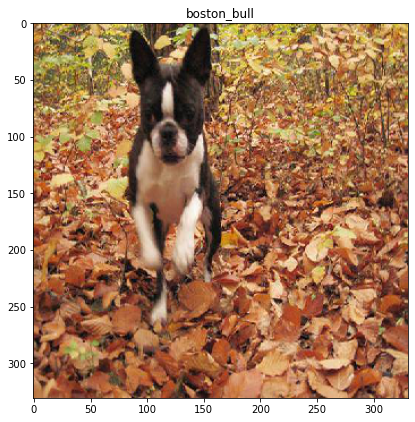

In [6]:
plt.figure(figsize=(40,40))
n=1
for i in range(n):
    ax = plt.subplot(5, 5, i+1)
    plt.title(breed[np.where(y[i] ==1)[0][0]])
    plt.imshow(X[i].astype('int32'))

In [7]:
lrr= ReduceLROnPlateau(monitor='val_accuracy', factor=.01, patience=3, min_lr=1e-5,verbose = 1)
EarlyStop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
batch_size= 128
epochs=50
learn_rate=.001
sgd=SGD(lr=learn_rate,momentum=.9,nesterov=False)
adam=Adam(lr=learn_rate, beta_1=0.9, beta_2=0.999, epsilon=None,  amsgrad=False)

C:\Users\Brion\anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
C:\Users\Brion\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [8]:
img_size = (331,331,3)
def getfeatures(model_name, model_preprocessor, input_size, data):
    input_layer = Input(input_size)
    preprocessor = Lambda(model_preprocessor)(input_layer)
    base_model = model_name(weights='imagenet', include_top=False,input_shape=input_size)(preprocessor)
    avg = GlobalAveragePooling2D()(base_model)
    feature_extractor = Model(inputs = input_layer, outputs = avg)
    feature_maps = feature_extractor.predict(data, verbose=1)
    print('Feature maps shape: ', feature_maps.shape)
    return feature_maps

In [9]:
print('InceptionV3 Feature Extraction')
inception_preprocessor = preprocess_input
inception_features = getfeatures(InceptionV3,inception_preprocessor,img_size, X)
print('Final feature maps shape', inception_features.shape)

InceptionV3 Feature Extraction
320/320 [==============================] - 339s 1s/step
Feature maps shape:  (10222, 2048)
Final feature maps shape (10222, 2048)


In [11]:
def images_to_array_test(test_path, img_size = (331,331,3)):
    test_filenames = [test_path + fname for fname in os.listdir(test_path)]
    data_size = len(test_filenames)
    images = np.zeros([data_size, img_size[0], img_size[1], 3], dtype=np.uint8)  
    for ix,img_dir in enumerate(tqdm(test_filenames)):
        img = load_img(img_dir, target_size = img_size)
        images[ix]=img
        del img
    print('Ouptut Data Size: ', images.shape)
    return images
test_data = images_to_array_test('Database1/test/', img_size)

  0%|          | 0/10357 [00:00<?, ?it/s]

Ouptut Data Size:  (10357, 331, 331, 3)


In [13]:
model = Sequential()
model.add(Dropout(0.7,input_shape=(inception_features.shape[1],)))
model.add(Dense(n_breed,activation= 'softmax'))
model.compile(optimizer=adam,loss='categorical_crossentropy',metrics=['accuracy'])
#Training the model. 
history = model.fit(inception_features, y,batch_size=batch_size,epochs=epochs,validation_split=0.2,callbacks=[lrr,EarlyStop])

Epoch 1/50
64/64 [==============================] - 0s 4ms/step - loss: 3.0397 - accuracy: 0.4359 - val_loss: 1.2235 - val_accuracy: 0.8778 - lr: 0.0010
Epoch 2/50
64/64 [==============================] - 0s 3ms/step - loss: 0.9022 - accuracy: 0.8458 - val_loss: 0.5270 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 3/50
64/64 [==============================] - 0s 3ms/step - loss: 0.5350 - accuracy: 0.8809 - val_loss: 0.3888 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 4/50
64/64 [==============================] - 0s 3ms/step - loss: 0.4216 - accuracy: 0.8951 - val_loss: 0.3328 - val_accuracy: 0.9120 - lr: 0.0010
Epoch 5/50
64/64 [==============================] - 0s 3ms/step - loss: 0.3542 - accuracy: 0.9079 - val_loss: 0.3053 - val_accuracy: 0.9144 - lr: 0.0010
Epoch 6/50
64/64 [==============================] - 0s 3ms/step - loss: 0.3155 - accuracy: 0.9157 - val_loss: 0.2868 - val_accuracy: 0.9193 - lr: 0.0010
Epoch 7/50
64/64 [==============================] - 0s 3ms/step - loss: 0.2891 - a

In [14]:
def extact_features(data):
    print('InceptionV3 Feature Extraction')
    inception_features = getfeatures(InceptionV3, inception_preprocessor, img_size, data)
    print('Final feature maps shape', inception_features.shape)
    gc.collect()
    return inception_features
test_features = extact_features(test_data)

InceptionV3 Feature Extraction
324/324 [==============================] - 343s 1s/step
Feature maps shape:  (10357, 2048)
Final feature maps shape (10357, 2048)


InceptionV3 Feature Extraction
1/1 [==============================] - 1s 701ms/step
Feature maps shape:  (1, 2048)
Final feature maps shape (1, 2048)
Predicted label: pug
Probability of prediction): 94.09708380699158 %


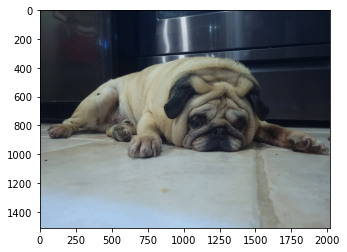

In [25]:
plt.imshow(mpimg.imread('Inputs/b.jpg'))
img_g = load_img('Inputs/b.jpg',target_size = img_size)
img_g = np.expand_dims(img_g, axis=0)
test_features = extact_features(img_g)
predg = model.predict(test_features)
print(f"Predicted label: {breed[np.argmax(predg[0])]}")
print(f"Probability of prediction): {(np.max(predg[0])) * 100} %")